Objectives

* Understand the idea behind Diffusion generative models: using score to enable reversal of diffusion process.
* Learn the score function by learning to denoise data.
* Hands-on experience in learning the score to a generate certain distribution.


### How to use this notebook today
- Run top-to-bottom; cells marked "Coding Exercise" need your edits before downstream tests will pass.
- Keep an eye on shapes and scales (especially sigma_t); most bugs come from mismatched broadcasting.
- Minimal path if time is short: interactive score visualizations -> reverse SDE coding cell -> DSM loss coding cell -> quick sampler run.
- Stretch goals: tune Lambda, nsteps, and compare how samples change.


In [1]:
# @markdown
from IPython.display import IFrame
from ipywidgets import widgets

---
# Setup

##  Install dependencies


In [2]:
# @title Install dependencies
# !pip install pillow --quiet
# !pip install seaborn --quiet

In [3]:
# Imports
import random
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

##  Figure settings


In [4]:
# @title Figure settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets

##  Plotting functions


In [5]:
# @title Plotting functions
import logging
import pandas as pd
import matplotlib.lines as mlines
logging.getLogger('matplotlib.font_manager').disabled = True
plt.rcParams['axes.unicode_minus'] = False
# You may have functions that plot results that aren't
# particularly interesting. You can add these here to hide them.

def plotting_z(z):
  """This function multiplies every element in an array by a provided value

  Args:
    z (ndarray): neural activity over time, shape (T, ) where T is number of timesteps

   """

  fig, ax = plt.subplots()

  ax.plot(z)
  ax.set(
      xlabel='Time (s)',
      ylabel='Z',
      title='Neural activity over time'
      )


def kdeplot(pnts, label="", ax=None, titlestr=None, handles=[], color="", **kwargs):
  if ax is None:
    ax = plt.gca()#figh, axs = plt.subplots(1,1,figsize=[6.5, 6])
  sns.kdeplot(x=pnts[:,0], y=pnts[:,1], ax=ax, label=label, color=color, **kwargs)
  handles.append(mlines.Line2D([], [], color=color, label=label))
  if titlestr is not None:
    ax.set_title(titlestr)


def quiver_plot(pnts, vecs, *args, **kwargs):
  plt.quiver(pnts[:, 0], pnts[:,1], vecs[:, 0], vecs[:, 1], *args, **kwargs)


def gmm_pdf_contour_plot(gmm, xlim=None,ylim=None,ticks=100,logprob=False,label=None,**kwargs):
    if xlim is None:
        xlim = plt.xlim()
    if ylim is None:
        ylim = plt.ylim()
    xx, yy = np.meshgrid(np.linspace(*xlim, ticks), np.linspace(*ylim, ticks))
    pdf = gmm.pdf(np.dstack((xx,yy)))
    if logprob:
        pdf = np.log(pdf)
    plt.contour(xx, yy, pdf, **kwargs,)


def visualize_diffusion_distr(x_traj_rev, leftT=0, rightT=-1, explabel=""):
  if rightT == -1:
    rightT = x_traj_rev.shape[2]-1
  figh, axs = plt.subplots(1,2,figsize=[12,6])
  sns.kdeplot(x=x_traj_rev[:,0,leftT], y=x_traj_rev[:,1,leftT], ax=axs[0])
  axs[0].set_title("Density of Gaussian Prior of $x_T$\n before reverse diffusion")
  plt.axis("equal")
  sns.kdeplot(x=x_traj_rev[:,0,rightT], y=x_traj_rev[:,1,rightT], ax=axs[1])
  axs[1].set_title(f"Density of $x_0$ samples after {rightT} step reverse diffusion")
  plt.axis("equal")
  plt.suptitle(explabel)
  return figh

In [6]:
def indiv_gauss_pdf_contour_plot(
    gmm,
    xlim=None,
    ylim=None,
    ticks=100,
    levels=20,
    cmap='viridis',
    linewidths=1.0,
    alpha=0.9,
):
    """Plot PDF contours for every Gaussian component using the current axes."""
    import numpy as np
    import matplotlib.pyplot as plt

    ax = plt.gca()
    if xlim is None:
        xlim = plt.xlim()
    if ylim is None:
        ylim = plt.ylim()

    xx, yy = np.meshgrid(
        np.linspace(*xlim, ticks),
        np.linspace(*ylim, ticks)
    )
    pos = np.dstack((xx, yy))

    colors = plt.get_cmap(cmap)(np.linspace(0.15, 0.85, gmm.n_component))

    for idx, (rv, mean, color) in enumerate(zip(gmm.RVs, gmm.mus, colors)):
        pdf = rv.pdf(pos)
        ax.contour(
            xx,
            yy,
            pdf,
            levels=levels,
            colors=[color],
            linewidths=linewidths,
            alpha=alpha,
        )
        ax.scatter(
            mean[0],
            mean[1],
            marker='x',
            s=80,
            color=color,
            label=f"Gaussian {idx + 1}",
        )

    return ax

##  Set random seed


 Executing `set_seed(seed=seed)` you are setting the seed


In [7]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

##  Set device (GPU or CPU). Execute `set_device()`


In [8]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# Inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [9]:
SEED = 1337
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 1337 has been set.


### A quick reminder: SDEs, drift, and diffusion

Before we write down our specific SDE, let’s recall the standard form of a (scalar) Itô SDE:

$$
dX_t = \mu(X_t, t)\,dt + \sigma(X_t, t)\,dW_t.
$$

- The term $\mu(X_t, t)$ is called the **drift**. It describes the *deterministic* tendency of the process (average rate of change).
- The term $\sigma(X_t, t)\,dW_t$ is the **diffusion** or **noise** term. It adds random fluctuations. Here $W_t$ is a Wiener process (Brownian motion), and $dW_t$ is its infinitesimal increment.

If we discretize time with step size $\Delta t$ and use Euler-Maruyama, we get an update of the form

$$
X_{t+\Delta t}
  \approx X_t
  + \mu(X_t, t)\,\Delta t
  + \sigma(X_t, t)\,\sqrt{\Delta t}\,Z_t,
$$

where $Z_t \sim \mathcal{N}(0, 1)$ are i.i.d. normal random variables.

- The **drift** term $\mu(X_t, t)\,\Delta t$ pushes the trajectory in a preferred direction (on average).
- The **diffusion** term $\sigma(X_t, t)\sqrt{\Delta t}\,Z_t$ adds Gaussian noise whose strength is controlled by $\sigma$.

---

### Pure diffusion SDE

If we set the drift to zero, $\mu \equiv 0$, we obtain a **pure diffusion SDE**:

$$
dX_t = \sigma(X_t, t)\,dW_t.
$$

- There is **no deterministic drift**: on average, the process does not “want” to go left or right.
- The entire evolution comes from the Brownian noise.

A simple and very important example is **Brownian motion with constant diffusion**:

$$
dX_t = \sigma\,dW_t,
$$

where $\sigma > 0$ is a constant. In this case:

- The conditional distribution given $X_0$ is
  $$
  X_t \mid X_0 \sim \mathcal{N}\bigl(X_0,\,\sigma^2 t\bigr),
  $$
  so the **mean stays at $X_0$** and the **variance grows linearly** with time.
- Intuitively, the process performs a random walk around its initial value, with uncertainty spreading out over time.

In our diffusion tutorial, we work with a **vector-valued** version of this idea:

$$
d\mathbf{x}(t) = g(t)\,d\mathbf{w}(t),
$$

where
- $\mathbf{x}(t) \in \mathbb{R}^d$ is a vector (e.g. all pixels of an image),
- $\mathbf{w}(t)$ is a $d$-dimensional Wiener process,
- $g(t) \ge 0$ is a scalar diffusion coefficient.

This is what we mean by a **no-drift pure diffusion SDE**: there is no explicit drift term, only a time-dependent diffusion magnitude $g(t)$ multiplying Brownian noise.


### Code example

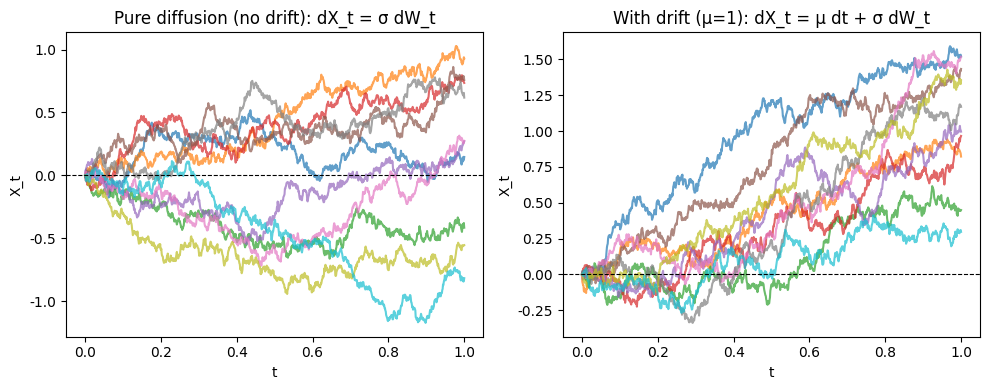

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
T = 1.0          # final time
N = 1000         # number of time steps
dt = T / N
times = np.linspace(0.0, T, N + 1)

sigma = 0.5      # diffusion coefficient
mu = 1.0         # drift coefficient for the "with drift" example
n_paths = 10      # number of sample paths to simulate

rng = np.random.default_rng(1337)

def simulate_paths(mu_val):
    """
    Simulate n_paths trajectories of the 1D SDE:
        dX_t = mu_val * dt + sigma * dW_t
    using Euler-Maruyama:
        X_{t+dt} = X_t + mu_val * dt + sigma * sqrt(dt) * Z_t
    """
    X = np.zeros((n_paths, N + 1), dtype=np.float64)
    X[:, 0] = 0.0  # start at X_0 = 0 for all paths

    for i in range(N):
        Z = rng.normal(size=n_paths)
        X[:, i + 1] = X[:, i] + mu_val * dt + sigma * np.sqrt(dt) * Z

    return X

# Pure diffusion: mu = 0
X_pure = simulate_paths(mu_val=0.0)

# With drift: mu = 1
X_drift = simulate_paths(mu_val=mu)

# Plot a few sample paths
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax = axes[0]
for k in range(n_paths):
    ax.plot(times, X_pure[k], alpha=0.7)
ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
ax.set_title("Pure diffusion (no drift): dX_t = σ dW_t")
ax.set_xlabel("t")
ax.set_ylabel("X_t")

ax = axes[1]
for k in range(n_paths):
    ax.plot(times, X_drift[k], alpha=0.7)
ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
ax.set_title("With drift (μ=1): dX_t = μ dt + σ dW_t")
ax.set_xlabel("t")
ax.set_ylabel("X_t")

plt.tight_layout()
plt.show()


# Section 1: Understanding Score-Based Models and Diffusion

## Score-based models vs. diffusion models

In the literature, **score-based models** and **diffusion models** are often treated as almost synonymous. Historically, they arose from two slightly different lines of work, with different formulations and notations:

- **Diffusion models** (e.g. Ho et al.) use a **discrete Markov chain** as the forward process. The model is a latent-variable model over a trajectory
  $$
  \mathbf{x}_{0:T} = (\mathbf{x}_0, \mathbf{x}_1, \dots, \mathbf{x}_T),
  $$
  with joint
  $$
  p_\theta(\mathbf{x}_{0:T})
  = p(\mathbf{x}_T)\,\prod_{t=1}^T p_\theta(\mathbf{x}_{t-1} \mid \mathbf{x}_t),
  $$
  and a known forward (noising) process
  $$
  q(\mathbf{x}_{1:T} \mid \mathbf{x}_0)
  = \prod_{t=1}^T q(\mathbf{x}_t \mid \mathbf{x}_{t-1}, \mathbf{x}_0).
  $$
  The training objective is the **Evidence Lower Bound (ELBO)** on the data log-likelihood:
  $$
  \log p_\theta(\mathbf{x}_0)
  \;\ge\;
  \mathcal{L}_{\text{ELBO}}(\mathbf{x}_0; \theta)
  :=
  \mathbb{E}_{q(\mathbf{x}_{1:T} \mid \mathbf{x}_0)}
  \bigl[
    \log p_\theta(\mathbf{x}_{0:T})
    - \log q(\mathbf{x}_{1:T} \mid \mathbf{x}_0)
  \bigr].
  $$
  In DDPM-style models, this ELBO can be rewritten as a sum of KL terms plus a simple Gaussian reconstruction term, and is further simplified to the familiar **noise-prediction MSE loss**.

- **Score-based models** (e.g. Song & Ermon) use a **continuous-time stochastic differential equation (SDE)** as the forward process. The model learns the **score**
  $$
  \nabla_{\mathbf{x}} \log p_t(\mathbf{x})
  $$
  of the perturbed data distribution $p_t$ at different noise levels. A typical continuous-time denoising score matching objective has the form
  $$
  \mathcal{L}_{\text{DSM}}(\theta)
  =
  \mathbb{E}_{t,\,\mathbf{x}_0,\,\mathbf{z}}
  \Bigl[
    \lambda(t)\,
    \bigl\|
      s_\theta(\mathbf{x}_t, t)
      - \nabla_{\mathbf{x}_t} \log p(\mathbf{x}_t \mid \mathbf{x}_0)
    \bigr\|_2^2
  \Bigr],
  $$
  where $\mathbf{x}_t$ is a noisy version of $\mathbf{x}_0$, $\mathbf{z}$ is Gaussian noise, and $\lambda(t)$ is a weighting function.

It was later shown that these views are essentially equivalent: under suitable assumptions, the discrete diffusion chain can be seen as an Euler-Maruyama discretization of a corresponding SDE, and the ELBO-based objective reduces to a score-matching-like loss.

In this section we focus on the **continuous-time** viewpoint, because it makes the “data + Gaussian noise” structure especially transparent. In the next sections we will switch to the standard **discrete DDPM-style** formulation used in most implementations and relate it back to this SDE perspective.

---

## Section 1.1: Forward diffusion as an SDE

We now move from the 1D example to a **vector-valued** SDE and use it to describe the forward diffusion process that gradually corrupts data with Gaussian noise.

As a simple model, consider a **pure diffusion SDE** (no drift), also known as a variance-exploding SDE (VE SDE) in the score-based modeling literature:

$$
d\mathbf{x}(t) = g(t)\,d\mathbf{w}(t),
$$

where

- $\mathbf{w}(t)$ is a standard Wiener process (Brownian motion) in $\mathbb{R}^d$,
- $d\mathbf{w}(t)$ is its infinitesimal increment,
- $g(t) \ge 0$ is a scalar diffusion coefficient.

This is the vector-valued analogue of the scalar SDE
$dX_t = \sigma\,dW_t$ from the reminder section, but with a **time-dependent** noise scale $g(t)$.

A simple time-discretization with step size $\Delta t$ (Euler-Maruyama) is

$$
\mathbf{x}_{t+\Delta t}
  = \mathbf{x}_t + g(t)\,\sqrt{\Delta t}\,\mathbf{z}_t,
$$

where $\mathbf{z}_t \sim \mathcal{N}(\mathbf{0}, I)$ are i.i.d. Gaussian random vectors.

---

### Conditional distribution given the initial state

Let $\mathbf{x}_0$ be a sample from the data distribution $p_0(\mathbf{x}_0)$. For a fixed time $t$, the SDE solution implies that the conditional distribution of $\mathbf{x}_t$ given $\mathbf{x}_0$ is Gaussian:

$$
p(\mathbf{x}_t \mid \mathbf{x}_0)
= \mathcal{N}\bigl(\mathbf{x}_t;\,\mathbf{x}_0,\sigma_t^2 I\bigr),
$$

where the variance (noise scale) $\sigma_t^2$ is the **integrated diffusion** up to time $t$:

$$
\sigma_t^2
= \int_0^t g^2(\tau)\,d\tau.
$$

Thus, as $t$ increases, the conditional distribution spreads out around $\mathbf{x}_0$ with growing variance $\sigma_t^2$, but its **mean remains at $\mathbf{x}_0$** because there is no drift.

---

### Marginal distribution at time $t$

If we marginalize over the initial data $\mathbf{x}_0 \sim p_0(\mathbf{x}_0)$, we obtain the marginal distribution $p_t(\mathbf{x})$ of $\mathbf{x}_t$:

$$
p_t(\mathbf{x})
= \int p_0(\mathbf{x}_0)\,
   \mathcal{N}\bigl(\mathbf{x};\,\mathbf{x}_0,\sigma_t^2 I\bigr)\,
   d\mathbf{x}_0.
$$

Equivalently, $p_t$ is the **Gaussian convolution** of the data distribution $p_0$ with
$\mathcal{N}(\mathbf{0},\sigma_t^2 I)$. As $t$ grows,
$p_t$ becomes a more and more blurred version of the data distribution.


---

> **Remark (connection to DDPM-style chains).**  
> The SDE above is a convenient continuous-time model in which $p(\mathbf{x}_t \mid \mathbf{x}_0)$ is centered at $\mathbf{x}_0$. In practice, most diffusion implementations (DDPM) use a *variance-preserving* forward process of the form
> $$
> x_t = \sqrt{\bar{\alpha}_t}\,x_0 + \sqrt{1-\bar{\alpha}_t}\,\varepsilon,
> \quad
> \varepsilon \sim \mathcal{N}(0,I),
> $$
> where the conditional mean is $\sqrt{\bar{\alpha}_t}\,x_0$ rather than $x_0$. Later in the notebook we will work with this DDPM-style formulation in code and relate it back to the continuous-time perspective.

---

### Interactive Demo 1.1: Visualizing diffusion in 1D

We now visualize how a **bimodal** 1D distribution evolves under a pure diffusion SDE.

- At time $t = 0$, we sample $x_0$ from a mixture of two Gaussians (two “modes”).
- We then evolve each sample according to
  $$
  dX_t = g(t)\,dW_t, \quad g(t) = \lambda^t,
  $$
  using an Euler-Maruyama discretization:
  $$
  X_{t+\Delta t} \approx X_t + g(t)\,\sqrt{\Delta t}\,Z_t,
  \quad Z_t \sim \mathcal{N}(0,1).
  $$
- As time increases, the two modes gradually blur and overlap: the marginal $p_t(x)$ becomes closer to a single broad “lump”.

Use the slider to change $\lambda$ and see how the diffusion strength affects the mixing of the two modes.


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets

# @title 1D diffusion process
@widgets.interact(lambda_value=widgets.FloatSlider(value=1.0, min=0.0, max=50.0, step=1.0))
def diffusion_1d_forward(lambda_value):
    """
    Simulate a 1D pure diffusion SDE
        dX_t = g(t) dW_t,  g(t) = lambda_value^t
    for many particles starting from a bimodal distribution.

    We discretize time with step dt and use Euler-Maruyama:
        X_{t+dt} = X_t + g(t) * sqrt(dt) * Z_t,  Z_t ~ N(0,1).
    """

    np.random.seed(42)  # fixed seed so changing lambda_value is comparable

    timesteps = 200
    sampleN = 400

    # time grid t in [0, 1]
    t = np.linspace(0.0, 1.0, timesteps)
    dt = t[1] - t[0]

    # Brownian increments: dW_t ~ N(0, dt)
    dW = np.random.normal(loc=0.0, scale=np.sqrt(dt), size=(timesteps, sampleN))

    # Initial positions x_0 from a bimodal distribution:
    # left mode ~ N(-5, 1), right mode ~ N(5, 1)
    x0_left = np.random.normal(loc=-5.0, scale=1.0, size=(sampleN // 2,))
    x0_right = np.random.normal(loc=5.0, scale=1.0, size=(sampleN - sampleN // 2,))
    x0 = np.concatenate([x0_left, x0_right], axis=0)

    # Diffusion coefficient g(t) = lambda_value^t
    g_t = (lambda_value ** t)[:, None]   # shape [T, 1]

    # Forward simulation:
    # X_{t+dt} = X_t + g(t) * dW_t
    # We accumulate the increments and add x0:
    X = np.cumsum(g_t * dW, axis=0) + x0.reshape(1, sampleN)

    # ------------------------------------------------------------------
    # Plot: (1) trajectories, (2) histogram at final time
    # ------------------------------------------------------------------
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    ax_traj, ax_hist = axes

    # Plot trajectories: first mode in red, second mode in blue
    ax_traj.plot(t, X[:, :sampleN // 2], alpha=0.1, color="r")  # left mode
    ax_traj.plot(t, X[:, sampleN // 2:], alpha=0.1, color="b")  # right mode
    ax_traj.set_xlabel("time t")
    ax_traj.set_ylabel("X_t")
    ax_traj.set_title(r"Sample paths, $dX_t = g(t)\,dW_t$, $g(t)=\lambda^t$")
    ax_traj.grid(True)

    # Histogram of X_T (final time) to approximate p_T(x)
    x_T = X[-1]
    ax_hist.hist(x0, bins=40, density=True, alpha=0.4, label="t = 0 (bimodal)")
    ax_hist.hist(x_T, bins=40, density=True, alpha=0.7, label="t = 1 (diffused)")
    ax_hist.set_xlabel("x")
    ax_hist.set_ylabel("density")
    ax_hist.set_title("Marginal density at t = 0 vs t = 1")
    ax_hist.legend()

    plt.tight_layout()
    plt.show()


interactive(children=(FloatSlider(value=1.0, description='lambda_value', max=50.0, step=1.0), Output()), _dom_…

#### Questions

1. **Effect of $\lambda$ on trajectories**

   - Try `lambda_value = 0.0`, `1.0`, and `5.0` (you can input the value directly).
   - How do the trajectories change as you increase $\lambda$?

2. **Mixing of the two modes**

   - Look at the histogram on the right for `lambda_value = 0.0`, `5.0`, and `10.0`.
   - At $t = 10$, can you still clearly distinguish the two modes, or do they merge into a single broad bump? What about $t = 50$ ?
   - How does this illustrate the idea that diffusion can destroy multi-modal structure in $p_t(x)$?

3. **Connecting $g(t)$ to variance**

   - Recall that for the SDE $dX_t = g(t)\,dW_t$, the variance is
     $$
     \sigma_t^2 = \int_0^t g(\tau)^2\,d\tau.
     $$
   - For `lambda_value = 1.0`, we have $g(t) = 1$. Compute $\sigma_t^2$ as a function of $t$.
   - Does the growth of the variance you compute match the spreading you observe in the trajectories when `lambda_value = 1.0`?


####  2D diffusion process


 (the animation takes a while to render)


In [12]:
# @title 2D diffusion process
# @markdown (the animation takes a while to render)
Lambda = 26  # @param {type:"slider", min:1, max:50, step:1}
timesteps = 50
sampleN = 200
t = np.linspace(0, 1, timesteps)
# Generate random normal samples for the Wiener process
dw = np.random.normal(0, np.sqrt(t[1] - t[0]), size=(len(t), 2, sampleN))  # Three-dimensional array for multiple trajectories
# Sample initial positions from a bimodal distribution
x0 = np.concatenate((np.random.normal(-2, .2, size=(2,sampleN//2)),
                     np.random.normal(2, .2, size=(2,sampleN - sampleN//2))),
                    axis=-1)
# Compute the diffusion process for multiple trajectories
x = np.cumsum((Lambda**t)[:, None, None] * dw, axis=0) + x0[None, :, :]  # Broadcasting x0 to match the shape of dw

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(-25, 25)
ax.set_ylim(-25, 25)
ax.axis("image")
# Create an empty scatter plot
scatter1 = ax.scatter([], [], color="r", alpha=0.5)
scatter2 = ax.scatter([], [], color="b", alpha=0.5)
# Update function for the animation
def update(frame):
  ax.set_title(f'Time Step: {frame}')
  scatter1.set_offsets(x[frame, :, :sampleN//2].T)
  scatter2.set_offsets(x[frame, :, sampleN//2:].T)
  return scatter1, scatter2

# Create the animation
animation = FuncAnimation(fig, update, frames=range(timesteps), interval=100, blit=True)
# Display the animation
plt.close()  # Prevents displaying the initial static plot
HTML(animation.to_html5_video()) #  to_jshtml

## Section 1.2:  What is Score

The big idea of diffusion model is to use the **"score" function** to reverse the diffusion process. So what is score, what's the intuition to it?

The **Score** is the gradient of the log data distribution, so it tells us which direction to go to increase the probability of data.

\begin{equation}
\mathbf{s}(\mathbf{x})=\nabla \log p(\mathbf{x})
\end{equation}

### Coding Exercise 1.2: Score for Gaussian Mixtures

In this exercise, you will explore the score function of a Gaussian mixture to gain more intuition about its geometry.

####   Custom Gaussian Mixture class


 *Execute this cell to define the class Gaussian Mixture Model for our exercise*


In [ ]:
from scipy.stats import multivariate_normal

class GaussianMixture:
  def __init__(self, mus, covs, weights):
    """
    mus: a list of K 1d np arrays (D,)
    covs: a list of K 2d np arrays (D, D)
    weights: a list or array of K unnormalized non-negative weights, signifying the possibility of sampling from each branch.
      They will be normalized to sum to 1. If they sum to zero, it will err.
    """
    self.n_component = len(mus)
    self.mus = mus
    self.covs = covs
    self.precs = [np.linalg.inv(cov) for cov in covs]
    self.weights = np.array(weights)
    self.norm_weights = self.weights / self.weights.sum()
    self.RVs = []
    for i in range(len(mus)):
      self.RVs.append(multivariate_normal(mus[i], covs[i]))
    self.dim = len(mus[0])

  def add_component(self, mu, cov, weight=1):
    self.mus.append(mu)
    self.covs.append(cov)
    self.precs.append(np.linalg.inv(cov))
    self.RVs.append(multivariate_normal(mu, cov))
    self.weights.append(weight)
    self.norm_weights = self.weights / self.weights.sum()
    self.n_component += 1

  def pdf_decompose(self, x):
    """
      probability density (PDF) at $x$.
    """
    component_pdf = []
    prob = None
    for weight, RV in zip(self.norm_weights, self.RVs):
        pdf = weight * RV.pdf(x)
        prob = pdf if prob is None else (prob + pdf)
        component_pdf.append(pdf)
    component_pdf = np.array(component_pdf)
    return prob, component_pdf

  def pdf(self, x):
    """
      probability density (PDF) at $x$.
    """
    prob = None
    for weight, RV in zip(self.norm_weights, self.RVs):
        pdf = weight * RV.pdf(x)
        prob = pdf if prob is None else (prob + pdf)
    # component_pdf = np.array([rv.pdf(x) for rv in self.RVs]).T
    # prob = np.dot(component_pdf, self.norm_weights)
    return prob

  def score(self, x):
    """
    Compute the score $\\nabla_x \\log p(x)$ for the given $x$.
    """
    component_pdf = np.array([rv.pdf(x) for rv in self.RVs]).T
    weighted_compon_pdf = component_pdf * self.norm_weights[np.newaxis, :]
    print("self.norm_weights:", self.norm_weights.shape, self.norm_weights)
    participance = weighted_compon_pdf / weighted_compon_pdf.sum(axis=1, keepdims=True)
    print("participance:", participance.shape, participance)

    scores = np.zeros_like(x)
    for i in range(self.n_component):
      gradvec = - (x - self.mus[i]) @ self.precs[i]
      scores += participance[:, i:i+1] * gradvec

    return scores

  def score_decompose(self, x):
    """
    Compute the grad to each branch for the score $\\nabla_x \\log p(x)$ for the given $x$.
    """
    component_pdf = np.array([rv.pdf(x) for rv in self.RVs]).T
    weighted_compon_pdf = component_pdf * self.norm_weights[np.newaxis, :]
    participance = weighted_compon_pdf / weighted_compon_pdf.sum(axis=1, keepdims=True)

    gradvec_list = []
    for i in range(self.n_component):
      gradvec = - (x - self.mus[i]) @ self.precs[i]
      gradvec_list.append(gradvec)
      # scores += participance[:, i:i+1] * gradvec

    return gradvec_list, participance

  def sample(self, N):
    """ Draw N samples from Gaussian mixture
    Procedure:
      Draw N samples from each Gaussian
      Draw N indices, according to the weights.
      Choose sample between the branches according to the indices.
    """
    rand_component = np.random.choice(self.n_component, size=N, p=self.norm_weights)
    all_samples = np.array([rv.rvs(N) for rv in self.RVs])
    gmm_samps = all_samples[rand_component, np.arange(N),:]
    return gmm_samps, rand_component, all_samples

### Example: Gaussian mixture model

In [14]:
# Gaussian mixture
mu1 = np.array([0, 1.0])
Cov1 = np.array([[1.0, 0.0], [0.0, 1.0]])

mu2 = np.array([2.0, -1.0])
Cov2 = np.array([[2.0, 0.5], [0.5, 1.0]])

gmm = GaussianMixture([mu1, mu2],[Cov1, Cov2], [1.0, 1.0])

In [15]:
set_seed(1337)
gmm_samples, _, _ = gmm.sample(5000)


Random seed 1337 has been set.


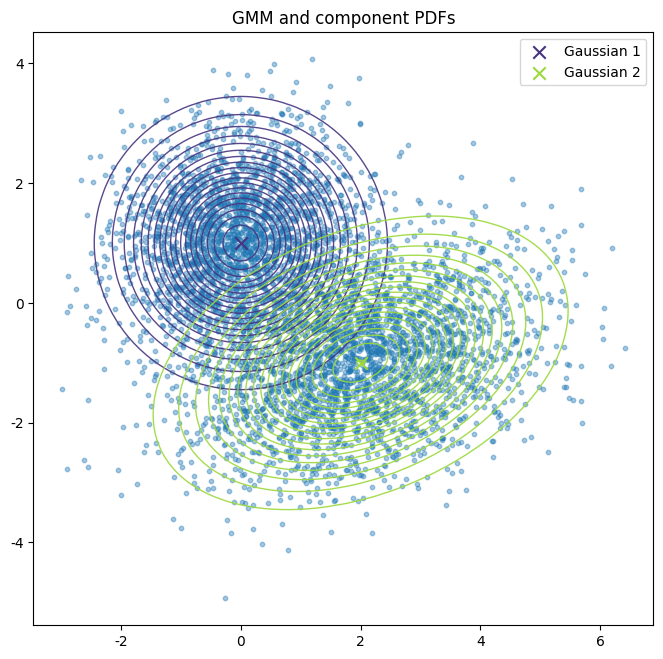

In [16]:
show_samples = True  # @param {type:"boolean"}
plt.figure(figsize=[8, 8])
plt.scatter(
    gmm_samples[:, 0],
    gmm_samples[:, 1],
    s=10,
    alpha=0.4 if show_samples else 0.0,
)
indiv_gauss_pdf_contour_plot(gmm, cmap="viridis", levels=20)
plt.title("GMM and component PDFs")
plt.axis("image")
plt.legend(loc="upper right")
plt.show()

####  Visualize log density


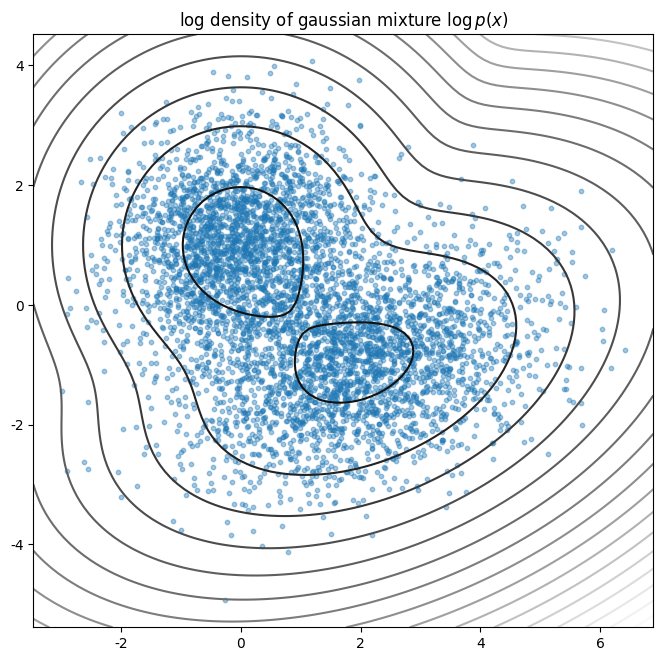

In [17]:
# @title Visualize log density
show_samples = True  # @param {type:"boolean"}
plt.figure(figsize=[8, 8])
plt.scatter(gmm_samples[:, 0],
            gmm_samples[:, 1],
            s=10,
            alpha=0.4 if show_samples else 0.0)
gmm_pdf_contour_plot(gmm, cmap="Greys", levels=20, logprob=True)
plt.title("log density of gaussian mixture $\\log p(x)$")
plt.axis("image")
plt.show()

####  Visualize Score


In [18]:
# @title Visualize Score
set_seed(2023)
gmm_samps_few, _, _ = gmm.sample(200)
scorevecs_few = gmm.score(gmm_samps_few)
gradvec_list, participance = gmm.score_decompose(gmm_samps_few)

Random seed 2023 has been set.
component_pdf: (200, 2) [[1.21402287e-01 1.44717362e-04]
 [4.10315906e-04 7.18753687e-02]
 [1.77434079e-03 4.11446393e-02]
 [5.20932752e-03 6.46453088e-09]
 [1.26953905e-01 3.36827083e-03]
 [1.26103568e-01 1.94130545e-04]
 [9.74504759e-02 1.83678799e-02]
 [1.83742229e-02 7.72710733e-02]
 [8.16248066e-06 3.37844658e-02]
 [5.02238501e-04 1.01734113e-01]
 [8.47933578e-02 7.25026930e-05]
 [6.46218312e-08 6.06136771e-03]
 [6.61773807e-02 3.46889183e-03]
 [1.87607136e-02 8.66956292e-02]
 [1.26248916e-01 1.62010288e-04]
 [6.34765222e-02 2.12064358e-04]
 [9.65492972e-02 2.87089505e-05]
 [7.22864185e-02 3.08307565e-02]
 [1.40686167e-01 3.09738152e-04]
 [5.99634538e-02 5.31633513e-03]
 [2.45066279e-02 1.73595295e-02]
 [3.16551241e-02 1.98909610e-04]
 [6.45867984e-03 5.65399605e-09]
 [1.60612250e-02 1.22110106e-07]
 [7.18316097e-02 2.70202479e-03]
 [2.08833546e-02 1.46671246e-02]
 [4.78462564e-02 3.92887791e-05]
 [6.50765842e-02 2.52412954e-02]
 [1.09795794e-01 1.26

####  Score for Gaussian mixture


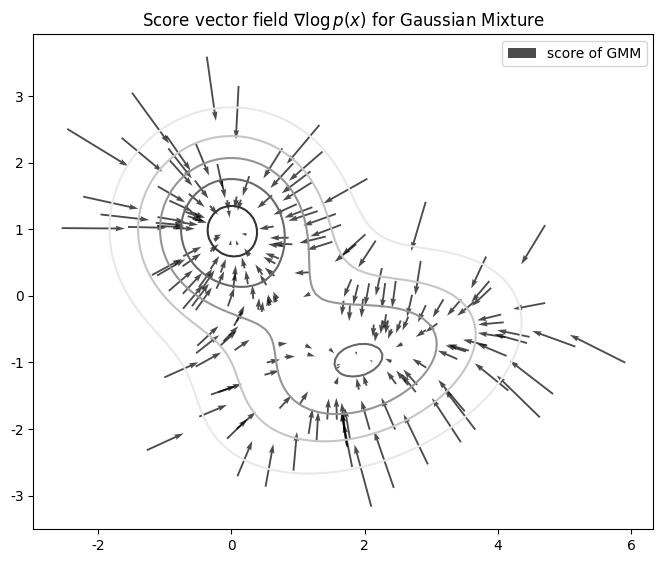

In [19]:
# @title Score for Gaussian mixture
plt.figure(figsize=[8, 8])
quiver_plot(gmm_samps_few, scorevecs_few,
            color="black", scale=25, alpha=0.7, width=0.003,
            label="score of GMM")
gmm_pdf_contour_plot(gmm, cmap="Greys")
plt.title("Score vector field $\\nabla\\log p(x)$ for Gaussian Mixture")
plt.axis("image")
plt.legend()
plt.show()

####  Score for each Gaussian mode


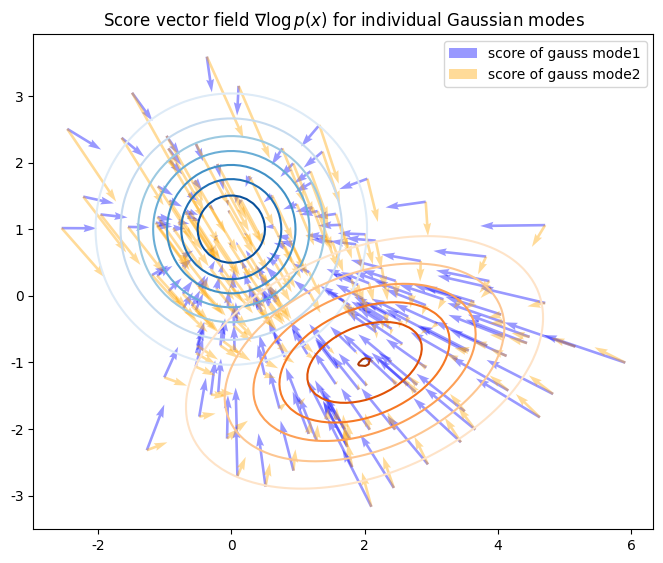

In [20]:
# @title Score for each Gaussian mode
plt.figure(figsize=[8, 8])
quiver_plot(gmm_samps_few, gradvec_list[0],
            color="blue", alpha=0.4, scale=45,
            label="score of gauss mode1")
quiver_plot(gmm_samps_few, gradvec_list[1],
            color="orange", alpha=0.4, scale=45,
            label="score of gauss mode2")
gmm_pdf_contour_plot(gmm.RVs[0], cmap="Blues")
gmm_pdf_contour_plot(gmm.RVs[1], cmap="Oranges")
plt.title("Score vector field $\\nabla\\log p(x)$ for individual Gaussian modes")
plt.axis("image")
plt.legend()
plt.show()

####  Compare Score of individual mode with that of the mixture.


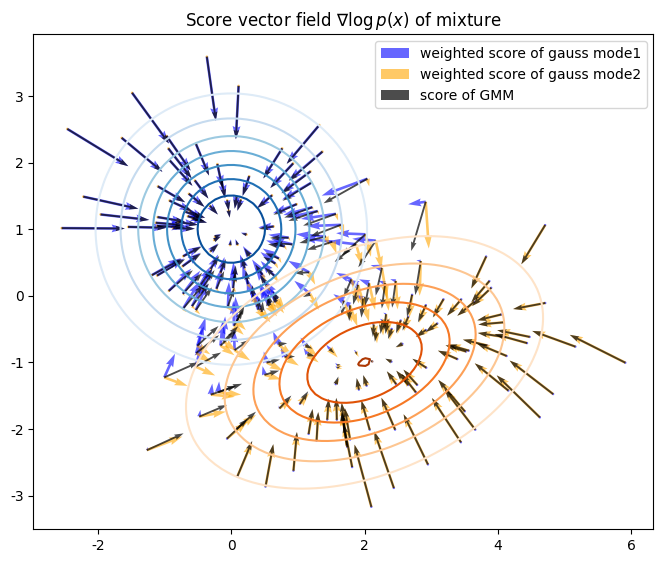

In [21]:
# @title Compare Score of individual mode with that of the mixture.
plt.figure(figsize=[8, 8])
quiver_plot(gmm_samps_few, gradvec_list[0]*participance[:, 0:1],
            color="blue", alpha=0.6, scale=25,
            label="weighted score of gauss mode1")
quiver_plot(gmm_samps_few, gradvec_list[1]*participance[:, 1:2],
            color="orange", alpha=0.6, scale=25,
            label="weighted score of gauss mode2")
quiver_plot(gmm_samps_few, scorevecs_few, color="black", scale=25, alpha=0.7,
            width=0.003, label="score of GMM")
gmm_pdf_contour_plot(gmm.RVs[0], cmap="Blues")
gmm_pdf_contour_plot(gmm.RVs[1], cmap="Oranges")
plt.title("Score vector field $\\nabla\\log p(x)$ of mixture")
plt.axis("image")
plt.legend()
plt.show()


### Think! 1.2: What does score tell us?

What does the score's **magnitude and direction** tell us in general?

For a **multi-modal distribution**, how does the score of the individual mode relate to the overall score?

Take 2 minutes to think in silence, then discuss as a group (~10 minutes).

<details><summary>Answer</summary>
Direction points toward higher-density regions (uphill), magnitude grows with distance from a mode. For a multi-modal distribution (e.g., GMM), the overall score is a weighted average of per-mode scores, dominated by nearby/high-density modes; each point’s score is pulled toward the closest modes.
</details>


## Section 1.3:  Reverse Diffusion

After getting some intuition about the score function, we are now well-equipped to reverse the diffusion process!

There is [a result in stochastic process literature](https://www.sciencedirect.com/science/article/pii/0304414982900515) that if we have the forward process

\begin{equation}
d\mathbf{x} = g(t)d \mathbf{w}
\end{equation}

Then the following process (reverse SDE) will be its time reversal:

\begin{equation}
d\mathbf{x} = -g^2(t) \nabla_\mathbf{x} \log p_t(\mathbf{x}) dt + g(t) d \mathbf{w}.
\end{equation}

where time $t$ runs backward.

<br>

**Time Reversal**: The solution of forward SDE is a sequence of distribution $p_t(\mathbf{x})$ from $t=0\to T$. If we start the reverse SDE with the initial distribution $p_T(\mathbf{x})$, then its solution will be the same sequence of distribution $p_t(\mathbf{x})$, but only that $t=T\to 0$.

**Note:** For the general form of this result, see the Bonus section at the end of this tutorial.

**Implication**  This time reversal is the foundation of the Diffusion model. We can use an interesting distribution as $p_0(\mathbf x)$ connects it with noise via forward diffusion.

Then we can sample the noise and convert it back to data via the reverse diffusion process.

<br>

<p align='center'><img src='https://github.com/NeuromatchAcademy/course-content-dl/blob/main/tutorials/W3D1_TimeSeriesAndNaturalLanguageProcessing/static/noising_process.png?raw=True'/></p>

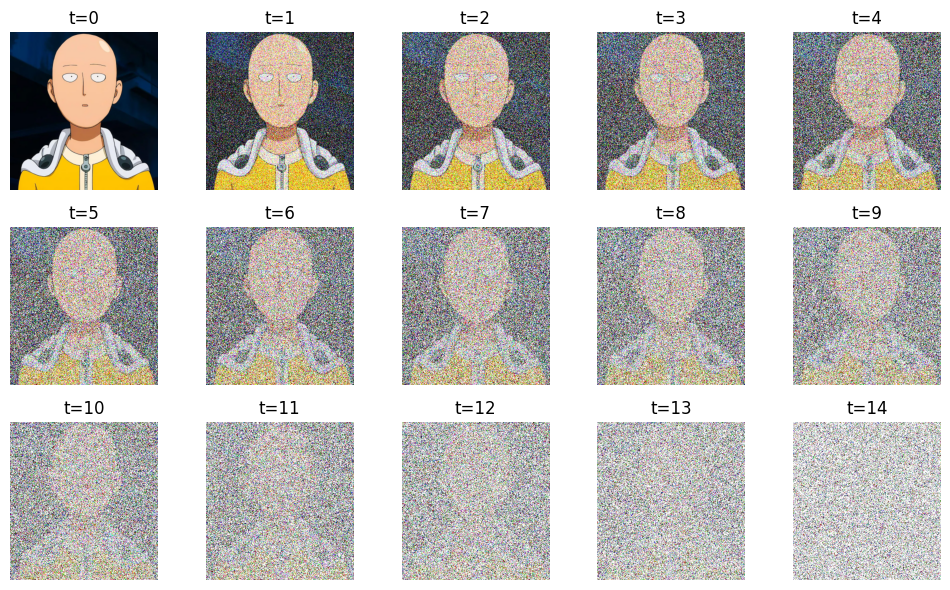

In [23]:
import math
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------------------------
# Load clean image x_0
# -------------------------------------------------------------------
img = plt.imread("saitama.png").astype(float)  # ensure float
# If the image is in [0, 255], you may want:
# img = img / 255.0
# We assume here that img is in [0, 1].

# -------------------------------------------------------------------
# Define a simple schedule for \bar{alpha}_t
# -------------------------------------------------------------------
timesteps = 15

# We construct \bar{alpha}_t in (0, 1], decreasing with t.
# Here we just use a simple linear schedule:
#   \bar{alpha}_t = 1 - lambda_t,  where lambda_t increases from 0 to 1.
# So:
#   t = 0       -> \bar{alpha}_0 ≈ 1   (almost no noise)
#   t = T - 1   -> \bar{alpha}_{T-1} ≈ 0 (almost pure noise)
alphas = 1.0 - np.linspace(0.0, 1.0, timesteps)  # here: alphas[t] = \bar{alpha}_t

# -------------------------------------------------------------------
# Forward diffusion: x_t = sqrt(\bar{alpha}_t) x_0 + sqrt(1-\bar{alpha}_t) eps
# -------------------------------------------------------------------
noisy_imgs = []
rng = np.random.default_rng(0)  # fixed seed for reproducibility

for alpha_bar_t in alphas:
    # eps ~ N(0, I) same shape as the image
    eps = rng.normal(loc=0.0, scale=1.0, size=img.shape)

    # DDPM-style forward noising:
    #   x_t = sqrt(\bar{alpha}_t) * x_0 + sqrt(1 - \bar{alpha}_t) * eps
    #
    # For small t: sqrt(\bar{alpha}_t) is close to 1 and sqrt(1 - \bar{alpha}_t) is close to 0
    #   -> x_t is close to x_0 (almost clean).
    # For large t: sqrt(\bar{alpha}_t) is small and sqrt(1 - \bar{alpha}_t) is large
    #   -> x_t is mostly noise.
    noisy = np.sqrt(alpha_bar_t) * img + np.sqrt(1.0 - alpha_bar_t) * eps

    # Clamp to [0, 1] for display (not part of the theory)
    noisy = np.clip(noisy, 0.0, 1.0)

    noisy_imgs.append(noisy)

# -------------------------------------------------------------------
# Plot x_t for all timesteps t
# -------------------------------------------------------------------
cols = min(timesteps, 5)                 # at most 5 columns
rows = math.ceil(timesteps / cols)
fig, axes = plt.subplots(rows, cols, figsize=(2 * cols, 2 * rows))
axes = np.atleast_1d(axes).reshape(rows, cols)

for t, im in enumerate(noisy_imgs):
    r, c = divmod(t, cols)
    ax = axes[r, c]
    if im.ndim == 2 or (im.ndim == 3 and im.shape[-1] == 1):
        ax.imshow(im.squeeze(), cmap="gray", vmin=0, vmax=1)
    else:
        ax.imshow(im, vmin=0, vmax=1)
    ax.axis("off")
    ax.set_title(f"t={t}")

# Hide unused subplots (if timesteps is not a multiple of cols)
for idx in range(len(noisy_imgs), rows * cols):
    r, c = divmod(idx, cols)
    axes[r, c].axis("off")

plt.tight_layout()
plt.show()


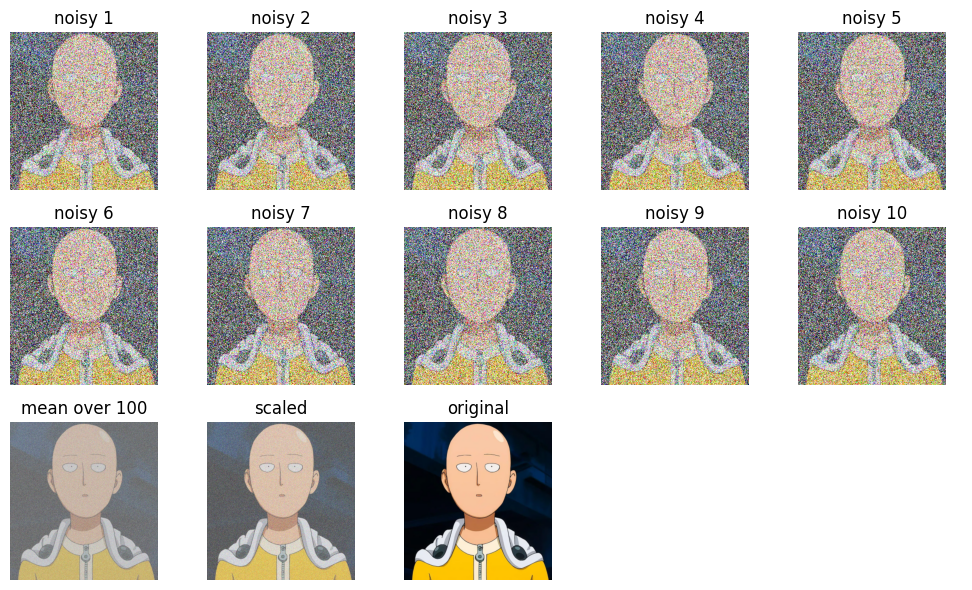

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------------------------
# Assumptions / notation
# -------------------------------------------------------------------
# img          : clean image x_0, scaled to [0, 1], shape [H, W] or [H, W, C]
# alphas       : array of cumulative products \bar{alpha}_t in (0, 1],
#                i.e. alphas[t] = \bar{alpha}_t = prod_{s=1..t} alpha_s
#
# Forward diffusion at step t (DDPM-style):
#   x_t = sqrt(\bar{alpha}_t) * x_0 + sqrt(1 - \bar{alpha}_t) * eps,
#   eps ~ N(0, I)
#
# We will:
#   1) Sample x_t^(k) for k = 1..N (N = num_samples),
#   2) Compute the empirical mean:
#        x̄_t = (1/N) * sum_k x_t^(k),
#   3) Use the law of large numbers:
#        x̄_t ≈ E[x_t] = sqrt(\bar{alpha}_t) * x_0,
#      and approximate:
#        x_0 ≈ x̄_t / sqrt(\bar{alpha}_t).
# -------------------------------------------------------------------

t = 4
alpha_bar_t = alphas[t]  # \bar{alpha}_t in (0, 1]

num_samples = 100        # how many noisy images to generate for averaging
max_show = 10            # show at most this many noisy images
rng = np.random.default_rng(0)  # fixed seed for reproducibility

# We'll accumulate:
# - the sum of all noisy images (for the mean),
# - the first 'max_show' noisy images (for visualization).
sum_noisy = np.zeros_like(img, dtype=np.float64)
noisy_first = []

for k in range(num_samples):
    # eps ~ N(0, I)
    eps = rng.normal(loc=0.0, scale=1.0, size=img.shape)

    # ----------------------------------------------------------------
    # Forward diffusion step:
    #   x_t^(k) = sqrt(\bar{alpha}_t) * x_0 + sqrt(1 - \bar{alpha}_t) * eps^(k)
    # where:
    #   - x_0 is the clean image,
    #   - eps^(k) is an independent noise sample for each k.
    # ----------------------------------------------------------------
    noisy = np.sqrt(alpha_bar_t) * img + np.sqrt(1.0 - alpha_bar_t) * eps

    # Clamp to [0, 1] for display (not part of the theory, just for images)
    noisy = np.clip(noisy, 0.0, 1.0)

    # Accumulate the sum for the empirical mean:
    #   x̄_t = (1/N) * sum_{k=1..N} x_t^(k)
    sum_noisy += noisy

    # Store the first 'max_show' samples for visualization
    if k < max_show:
        noisy_first.append(noisy)

# -------------------------------------------------------------------
# Empirical mean and its connection to E[x_t]
# -------------------------------------------------------------------
# Empirical mean:
#   x̄_t = (1/N) * sum_k x_t^(k)
#
# Substitute the forward equation:
#   x_t^(k) = sqrt(\bar{alpha}_t) * x_0 + sqrt(1 - \bar{alpha}_t) * eps^(k)
#
# Then:
#   x̄_t
#     = (1/N) * sum_k [ sqrt(\bar{alpha}_t) * x_0
#                      + sqrt(1 - \bar{alpha}_t) * eps^(k) ]
#     = sqrt(\bar{alpha}_t) * x_0
#       + sqrt(1 - \bar{alpha}_t) * (1/N) * sum_k eps^(k)
#
# Since E[eps^(k)] = 0 and eps^(k) are i.i.d., by the Law of Large Numbers:
#   (1/N) * sum_k eps^(k)  →  0  as N → ∞
#
# Therefore:
#   x̄_t  →  sqrt(\bar{alpha}_t) * x_0  as N → ∞,
# i.e. the mean image is a scaled but much cleaner version of x_0.
# -------------------------------------------------------------------
noisy_mean = (sum_noisy / num_samples).astype(np.float32)

# -------------------------------------------------------------------
# Approximate reconstruction of x_0 from the mean
# -------------------------------------------------------------------
# From the limit:
#   x̄_t ≈ sqrt(\bar{alpha}_t) * x_0
# we can approximately invert:
#   x_0 ≈ x̄_t / sqrt(\bar{alpha}_t).
#
# This is a *toy* denoising rule built from the forward process and
# the expectation, not the full DDPM reverse process, but it shows:
#   - Averaging cancels the noise,
#   - and dividing by sqrt(\bar{alpha}_t) recovers an approximation of x_0.
# -------------------------------------------------------------------
recon = noisy_mean / np.sqrt(alpha_bar_t)
recon = np.clip(recon, 0.0, 1.0)

# -------------------------------------------------------------------
# Plot: up to 10 noisy samples + mean + reconstruction
# -------------------------------------------------------------------
num_shown_noisy = min(max_show, num_samples)
num_panels = num_shown_noisy + 2  # (noisy samples) + mean + recon

cols = 5
rows = int(np.ceil(num_panels / cols))

fig, axes = plt.subplots(rows, cols, figsize=(2 * cols, 2 * rows))
axes = np.array(axes).ravel()

def show_image(ax, im, title):
    # If grayscale: [H, W] or [H, W, 1]
    if im.ndim == 2 or (im.ndim == 3 and im.shape[-1] == 1):
        ax.imshow(im.squeeze(), cmap='gray', vmin=0, vmax=1)
    else:
        # RGB case: [H, W, 3], no cmap to preserve colors
        ax.imshow(im, vmin=0, vmax=1)
    ax.set_title(title)
    ax.axis('off')

# 1) Show the first 'num_shown_noisy' noisy images x_t^(k)
for i in range(num_shown_noisy):
    show_image(axes[i], noisy_first[i], title=f"noisy {i+1}")

# 2) Show the mean image x̄_t ≈ sqrt(\bar{alpha}_t) * x_0
show_image(axes[num_shown_noisy],
           noisy_mean,
           title=f"mean over {num_samples}")

# 3) Show the approximate reconstruction x_0 ≈ x̄_t / sqrt(\bar{alpha}_t)
show_image(axes[num_shown_noisy + 1],
           recon,
           title="scaled")

# 4) True clean image x_0 for reference
show_image(axes[num_shown_noisy + 2],
           img,
           title="original")

# Hide any unused subplot cells
for j in range(num_panels, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [25]:
alpha_bar_t

np.float64(0.7142857142857143)


**Checkpoint before Coding Exercise 1.3**
- Intuition: reverse SDE adds noise *and* follows the score uphill; leaving out either term breaks sampling.
- Inputs you need: current sample x_t, noise scale g(t)=Lambda^t, score at time t from `gmm_t.score`.
- Expected behavior: early steps look noisy, later steps collapse toward mixture modes.


### Coding Exercise 1.3: Score enables reversal of diffusion

Here let's put our knowledge into action and see that the **score function** indeed enables the reverse diffusion and **the recovery of the initial distribution.**

In the following cell, you are going to implement the discretization of the reverse diffusion equation:

\begin{equation}
\mathbf{x}_{t-\Delta t} = \mathbf{x}_t + g(t)^2 s(\mathbf{x}_t, t)\Delta t + g(t)\sqrt{\Delta t} \mathbf{z}_t
\end{equation}

where $\mathbf{z}_t \sim \mathcal{N}(\mathbf{0}, I)$ and $g(t)=\lambda^t$.

In fact, this is the *sampling equation* for diffusion models in its simplest version.

 Helper functions: `sigma_t_square` and `diffuse_gmm`


In [26]:
# @markdown Helper functions: `sigma_t_square` and `diffuse_gmm`
def sigma_t_square(t, Lambda):
    """Compute the noise variance \sigma_t^2 of the conditional distribution
    for forward process with g(t)=\lambda^t

    Formula
      \sigma_t^2 = \frac{\sigma^{2\lambda} - 1}{2 \ln(\lambda)}

    Args:
      t (scalar or ndarray): time
      Lambda (scalar): Lambda

    Returns:
      sigma_t^2
    """
    return (Lambda**(2 * t) - 1) / (2 * np.log(Lambda))


def sigma_t(t, Lambda):
    """Compute the noise std \sigma_t of the conditional distribution
    for forward process with g(t)=\lambda^t

    Formula
      \sigma_t =\sqrt{ \frac{\sigma^{2\lambda} - 1}{2 \ln(\lambda)}}

    Args:
      t (scalar or ndarray): time
      Lambda (scalar): Lambda

    Returns:
      sigma_t
    """
    return np.sqrt((Lambda**(2 * t) - 1) / (2 * np.log(Lambda)))


def diffuse_gmm(gmm, t, Lambda):
  """ Teleport a Gaussian Mixture distribution to $t$ by diffusion forward process

  The distribution p_t(x) (still a Gaussian mixture)
    following the forward diffusion SDE
  """
  sigma_t_2 = sigma_t_square(t, Lambda)  # variance
  noise_cov = np.eye(gmm.dim) * sigma_t_2
  covs_dif = [cov + noise_cov for cov in gmm.covs]
  return GaussianMixture(gmm.mus, covs_dif, gmm.weights)

In [27]:

def reverse_diffusion_SDE_sampling_gmm(gmm, sampN=500, Lambda=5, nsteps=500):
  """ Using exact score function to simulate the reverse SDE to sample from distribution.

  gmm: Gausian Mixture model class defined above
  sampN: Number of samples to generate
  Lambda: the $\lambda$ used in the diffusion coefficient $g(t)=\lambda^t$
  nsteps: how many discrete steps do we use to
  """
  # initial distribution $N(0,sigma_T^2 I)$
  sigmaT2 = sigma_t_square(1, Lambda)
  xT = np.sqrt(sigmaT2) * np.random.randn(sampN, 2)
  x_traj_rev = np.zeros((*xT.shape, nsteps, ))
  x_traj_rev[:,:,0] = xT
  dt = 1 / nsteps
  for i in range(1, nsteps):
    # note the time fly back $t$
    t = 1 - i * dt

    # Sample the Gaussian noise $z ~ N(0, I)$
    eps_z = np.random.randn(*xT.shape)

    # Transport the gmm to that at time $t$ and
    gmm_t = diffuse_gmm(gmm, t, Lambda)

    # Compute the score at state $x_t$ and time $t$, $nabla \log p_t(x_t)$
    score_xt = gmm_t.score(x_traj_rev[:, :, i-1])

    # Implement the one time step update equation
    x_traj_rev[:, :, i] = x_traj_rev[:, :, i-1] + eps_z * (Lambda ** t) * np.sqrt(dt) + score_xt * dt * Lambda**(2*t)
  return x_traj_rev


[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main/tutorials/W2D4_GenerativeModels/solutions/W2D4_Tutorial2_Solution_c3981c22.py)

*Example output:*

<img alt='Solution hint' align='left' width=625.0 height=575.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W2D4_GenerativeModels/static/W2D4_Tutorial2_Solution_c3981c22_1.png>



---
# Section 2: Learning the score by denoising

So far, we have understood that the score function enables the time reversal of the diffusion process. But how to estimate it when we have no analytical form of the distribution?

For real datasets, we usually have no access to their density, not to mention their score. However, we have a set of samples $\{x_i\}$ from it. The way we estimate the score is called denoising score matching.

It can be shown that optimizing the upper objective, i.e., denoising score matching (DSM), is equivalent to optimizing the lower objective, i.e., explicit score matching, which minimizes the mean squared error (MSE) between the score model and the true time-dependent score.

\begin{equation}
J_{DSM}(\theta)=\mathbb E_{x\sim p_0(x)\\\tilde x\sim p_t(\tilde x\mid x)}\|s_\theta(\tilde x)-\nabla_\tilde x\log p_t(\tilde x\mid x)\|^2\\
J_{ESM}(\theta)=\mathbb E_{\tilde x\sim p_t(\tilde x)}\|s_\theta(\tilde x)-\nabla_\tilde x\log p_t(\tilde x)\|^2
\end{equation}

In both cases, the optimal $s_\theta(x)$ will be the same as the true score $\nabla_\tilde x\log p_t(\tilde x)$. Both objectives are equivalent in terms of their optimum.

Using the fact that the forward process has Gaussian conditional distribution $p_t(\tilde x\mid x)= \mathcal N(x,\sigma^2_t I)$, the objective can be simplified even further!

\begin{equation}
\mathbb E_{x\sim p_0(x)}\mathbb E_{z\sim \mathcal N(0,I)}\|s_\theta(x+\sigma_t z)+\frac{1}{\sigma_t}z\|^2
\end{equation}

To train the score model for all $t$ or noise levels, the objective is integrated over all time $t\in[\epsilon,1]$, with particular weighting $\gamma_t$ of different times:

\begin{equation}
\int_\epsilon^1dt \gamma_t\mathbb E_{x\sim p_0(x)}\mathbb E_{z\sim \mathcal N(0,I)}\|s_\theta(x+\sigma_t z, t)+\frac{1}{\sigma_t}z\|^2
\end{equation}

Here as a naive example, we choose weight $\gamma_t=\sigma_t^2$, which emphasizes the high noise period ($t\sim 1$) more than the low noise period ($t\sim 0$):

\begin{equation}
\int_\epsilon^1dt \mathbb E_{x\sim p_0(x)}\mathbb E_{z\sim \mathcal N(0,I)}\|\sigma_t s_\theta(x+\sigma_t z, t)+z\|^2
\end{equation}


To put it in plain language, this objective is simply doing the following steps:

1. Sample clean data $x$ from training distribution $x\sim p_0(x)$
2. Sample noise of same shape from i.i.d. Gaussian $z\sim \mathcal N(0,I)$
3. Sample time $t$ (or noise scale) and create noised data $\tilde x=x+\sigma_t z$
4. Predict the scaled noise at $(\tilde x,t)$ with neural network, minimize the MSE $\|\sigma_ts_\theta(\tilde x,t)+z\|^2$

The diffusion model is a rapidly progressing field with many different formulations. So when reading papers, don't be scared! They are all the same beast under various disguises.

* In many papers, including [stable diffusion](https://arxiv.org/abs/2112.10752), $-\sigma_t$ is absorbed into the score model, such that the objective looks like $\|\tilde s_\theta(x+\sigma_t z, t)-z\|^2$, which can be interpreted as inferring the noise from a noisy sample, highlighting the denoising nature.
  * In our code and notebook, we used $\|\sigma_t s_\theta(x+\sigma_t z, t)+z\|^2$ highlighting that it's matching the score.

* Another kind of forward process, i.e., Variance Preserving SDE, will scale down the signal by $\alpha_t$ while adding noise; for those, the objective will look like $\|\tilde s_\theta(\alpha_t x+\sigma_t z, t)-z\|^2$

* What's the best weighting function $\gamma_t$ and truncation $\epsilon$ is still a active area of research. There are many heuristic ways of setting them in actual diffusion models; see these very recent publications:
  * [arxiv:2303.00848](https://arxiv.org/abs/2303.00848)
  * [arxiv:2206.00364](https://arxiv.org/abs/2206.00364)
  * [arxiv:2106.05527](https://arxiv.org/abs/2106.05527)


### Think! 2: Denoising objective

Recall the discussion on the interpretation of the score for multi-modal distribution. How does that connect to the denoising objective?

In principle, can we optimize the score-matching objective to $0$, why?

Take 2 minutes to think in silence, then discuss as a group (~10 minutes).

<details><summary>Answer</summary>
You cannot drive the denoising objective to zero for real datasets: different data points with different noise draws can map to the same perturbed input $	ilde{x}$, so the network would need to output different targets simultaneously. The optimal score averages over those targets, so the loss stays above zero.
</details>


[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main/tutorials/W2D4_GenerativeModels/solutions/W2D4_Tutorial2_Solution_15da867a.py)




**Checkpoint before Coding Exercise 2 (DSM loss)**
- Goal: train a time-dependent score net so that `score * sigma_t ≈ -z` when you perturb data by `sigma_t * z`.
- Steps in code: sample t, sample Gaussian noise z, perturb x, predict score(x_t, t), compute \|sigma_t * score + z\|^2.
- Sanity checks: loss ~1e0-1e1 initially; dropping when training. If it is 0 instantly, something is off.


### Coding Exercise 2: Implementing Denoising Score Matching Objective

In this exercise, you are going to implement the DSM objective.

In [30]:

def loss_fn(model, x, sigma_t_fun, eps=1e-5):
  """The loss function for training score-based generative models.

  Args:
    model: A PyTorch model instance that represents a
      time-dependent score-based model.
      it takes x, t as arguments.
    x: A mini-batch of training data.
    sigma_t_fun: A function that gives the standard deviation of the conditional dist.
        p(x_t | x_0)
    eps: A tolerance value for numerical stability, sample t uniformly from [eps, 1.0]
  """
  random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
  z = torch.randn_like(x)
  std = sigma_t_fun(random_t, )
  perturbed_x = x + z * std[:, None]
  # use the model to predict score at x_t and t
  score = model(perturbed_x, random_t)
  # implement the loss \|\sigma_t s_	heta(x+\sigma_t z, t) + z\|^2
  loss = torch.mean(torch.sum((score * std[:, None] + z)**2, dim=(1)))
  return loss


[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main/tutorials/W2D4_GenerativeModels/solutions/W2D4_Tutorial2_Solution_1927e938.py)



A correctly implemented loss function shall pass the test below.

For a dataset with a single `0` datapoint, we have the analytical score is $\mathbf s(\mathbf x,t)=-\mathbf x/\sigma_t^2$. We test that, for this case, the analytical have zero loss.

####  Test loss function


In [31]:
# @title Test loss function
sigma_t_test = lambda t: sigma_t(t, Lambda=10)
score_analyt_test = lambda x_t, t: - x_t / sigma_t_test(t)[:, None]**2
x_test = torch.zeros(10, 2)
loss = loss_fn(score_analyt_test, x_test, sigma_t_test, eps=1e-3)
print(f"The loss is zero: {torch.allclose(loss, torch.zeros(1))}")

The loss is zero: True


/tmp/ipykernel_3924878/453161101.py:33: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return np.sqrt((Lambda**(2 * t) - 1) / (2 * np.log(Lambda)))


####  Define utils functions (Neural Network, and data sampling)


In [32]:
# @title Define utils functions (Neural Network, and data sampling)
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.nn.modules.loss import MSELoss
from tqdm.notebook import trange, tqdm

class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps.
  Basically it multiplexes a scalar `t` into a vector of `sin(2 pi k t)` and `cos(2 pi k t)` features.
  """
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, t):
    t_proj = t[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(t_proj), torch.cos(t_proj)], dim=-1)

class ScoreModel_Time(nn.Module):
  """A time-dependent score-based model."""

  def __init__(self, sigma, ):
    super().__init__()
    self.embed = GaussianFourierProjection(10, scale=1)
    self.net = nn.Sequential(nn.Linear(12, 50),
               nn.Tanh(),
               nn.Linear(50,50),
               nn.Tanh(),
               nn.Linear(50,2))
    self.sigma_t_fun = lambda t: np.sqrt(sigma_t_square(t, sigma))

  def forward(self, x, t):
    t_embed = self.embed(t)
    pred = self.net(torch.cat((x,t_embed),dim=1))
    # this additional steps provides an inductive bias.
    # the neural network output on the same scale,
    pred = pred / self.sigma_t_fun(t)[:, None,]
    return pred


def sample_X_and_score_t_depend(gmm, trainN=10000, sigma=5, partition=20, EPS=0.02):
  """Uniformly partition [0,1] and sample t from it, and then
  sample x~ p_t(x) and compute \nabla \log p_t(x)
  finally return the dataset x, score, t (train and test)
  """
  trainN_part = trainN // partition
  X_train_col, y_train_col, T_train_col = [], [], []
  for t in np.linspace(EPS, 1.0, partition):
    gmm_dif = diffuse_gmm(gmm, t, sigma)
    X_train,_,_ = gmm.sample(trainN_part)
    y_train = gmm.score(X_train)
    X_train_tsr = torch.tensor(X_train).float()
    y_train_tsr = torch.tensor(y_train).float()
    T_train_tsr = t * torch.ones(trainN_part)
    X_train_col.append(X_train_tsr)
    y_train_col.append(y_train_tsr)
    T_train_col.append(T_train_tsr)
  X_train_tsr = torch.cat(X_train_col, dim=0)
  y_train_tsr = torch.cat(y_train_col, dim=0)
  T_train_tsr = torch.cat(T_train_col, dim=0)
  return X_train_tsr, y_train_tsr, T_train_tsr

####  Test the Denoising Score Matching loss function


In [33]:
# @title Test the Denoising Score Matching loss function
def test_DSM_objective(gmm, epochs=500, seed=0):
  set_seed(seed)
  sigma = 25.0
  print("sampled 10000 (X, t, score) for training")
  X_train_samp, y_train_samp, T_train_samp = \
    sample_X_and_score_t_depend(gmm, sigma=sigma, trainN=10000,
                              partition=500, EPS=0.01)
  print("sampled 2000 (X, t, score) for testing")
  X_test_samp, y_test_samp, T_test_samp = \
    sample_X_and_score_t_depend(gmm, sigma=sigma, trainN=2000,
                              partition=500, EPS=0.01)
  print("Define neural network score approximator")
  score_model_td = ScoreModel_Time(sigma=sigma)
  sigma_t_f = lambda t: np.sqrt(sigma_t_square(t, sigma))
  optim = Adam(score_model_td.parameters(), lr=0.005)
  print("Minimize the denoising score matching objective")
  stats = []
  pbar = trange(epochs)  # 5k samples for 500 iterations.
  for ep in pbar:
    loss = loss_fn(score_model_td, X_train_samp, sigma_t_f, eps=0.01)
    optim.zero_grad()
    loss.backward()
    optim.step()
    pbar.set_description(f"step {ep} DSM objective loss {loss.item():.3f}")
    if ep % 25==0 or ep==epochs-1:
      # test the score prediction against the analytical score of the gmm.
      y_pred_train = score_model_td(X_train_samp, T_train_samp)
      MSE_train = MSELoss()(y_train_samp, y_pred_train)

      y_pred_test = score_model_td(X_test_samp, T_test_samp)
      MSE_test = MSELoss()(y_test_samp, y_pred_test)
      print(f"step {ep} DSM loss {loss.item():.3f} train score MSE {MSE_train.item():.3f} "+\
          f"test score MSE {MSE_test.item():.3f}")
      stats.append((ep, loss.item(), MSE_train.item(), MSE_test.item()))
  stats_df = pd.DataFrame(stats, columns=['ep', 'DSM_loss', 'MSE_train', 'MSE_test'])
  return score_model_td, stats_df


score_model_td, stats_df = test_DSM_objective(gmm, epochs=500, seed=SEED)

Random seed 1337 has been set.
sampled 10000 (X, t, score) for training
component_pdf: (20, 2) [[1.05139629e-01 4.51995469e-05]
 [4.70128531e-02 5.00636446e-02]
 [6.57744211e-02 7.72618655e-05]
 [6.24065249e-02 2.50573047e-04]
 [7.09672760e-02 5.05687907e-03]
 [2.24136941e-05 3.36763438e-02]
 [1.49330346e-01 6.36070823e-04]
 [1.94885365e-03 6.53749408e-02]
 [4.81657204e-08 7.76997717e-03]
 [1.42402402e-01 2.68387130e-03]
 [7.95944603e-02 5.05800836e-05]
 [1.38178334e-02 9.69427727e-02]
 [4.77254000e-02 4.10358670e-02]
 [2.49857133e-04 2.48545571e-02]
 [1.25243551e-01 1.59638206e-03]
 [1.89769534e-06 1.10639572e-02]
 [2.31851958e-02 6.02105205e-02]
 [6.68837713e-02 1.64664283e-02]
 [8.53527869e-03 1.66536886e-04]
 [4.86356172e-03 9.18648866e-02]]
self.norm_weights: (2,) [0.5 0.5]
participance: (20, 2) [[9.99570285e-01 4.29715458e-04]
 [4.84286663e-01 5.15713337e-01]
 [9.98826729e-01 1.17327093e-03]
 [9.96000883e-01 3.99911671e-03]
 [9.33483258e-01 6.65167415e-02]
 [6.65119303e-04 9.9933

  0%|          | 0/500 [00:00<?, ?it/s]

step 0 DSM loss 1.966 train score MSE 0.612 test score MSE 0.618


/tmp/ipykernel_3924878/2394546793.py:15: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  sigma_t_f = lambda t: np.sqrt(sigma_t_square(t, sigma))
/tmp/ipykernel_3924878/137541647.py:31: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  self.sigma_t_fun = lambda t: np.sqrt(sigma_t_square(t, sigma))


step 25 DSM loss 0.945 train score MSE 0.517 test score MSE 0.540
step 50 DSM loss 0.886 train score MSE 0.428 test score MSE 0.436
step 75 DSM loss 0.867 train score MSE 0.410 test score MSE 0.416
step 100 DSM loss 0.853 train score MSE 0.406 test score MSE 0.413
step 125 DSM loss 0.878 train score MSE 0.403 test score MSE 0.411
step 150 DSM loss 0.874 train score MSE 0.401 test score MSE 0.408
step 175 DSM loss 0.865 train score MSE 0.397 test score MSE 0.403
step 200 DSM loss 0.867 train score MSE 0.396 test score MSE 0.401
step 225 DSM loss 0.848 train score MSE 0.393 test score MSE 0.399
step 250 DSM loss 0.826 train score MSE 0.393 test score MSE 0.401
step 275 DSM loss 0.865 train score MSE 0.386 test score MSE 0.393
step 300 DSM loss 0.835 train score MSE 0.383 test score MSE 0.391
step 325 DSM loss 0.858 train score MSE 0.384 test score MSE 0.391
step 350 DSM loss 0.847 train score MSE 0.381 test score MSE 0.388
step 375 DSM loss 0.833 train score MSE 0.380 test score MSE 0.38

####  Plot the Loss


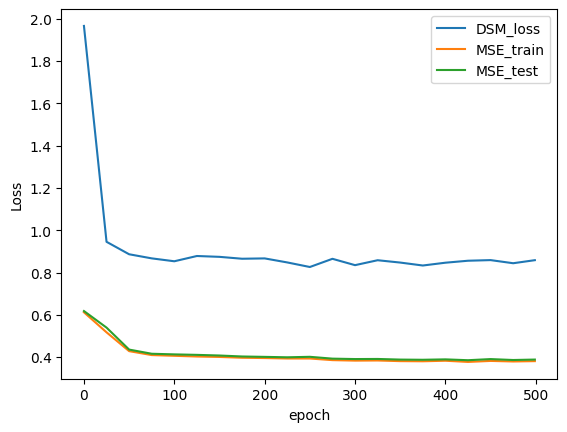

In [34]:
# @title Plot the Loss
stats_df.plot(x="ep", y=['DSM_loss', 'MSE_train', 'MSE_test'])
plt.ylabel("Loss")
plt.xlabel("epoch")
plt.show()

####  Test the Learned Score by Reverse Diffusion


Sample with reverse SDE using the trained score model


/tmp/ipykernel_3924878/137541647.py:31: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  self.sigma_t_fun = lambda t: np.sqrt(sigma_t_square(t, sigma))


Sample with reverse SDE using the exact score of Gaussian mixture
component_pdf: (1000, 2) [[0.00030591 0.00017285]
 [0.00147589 0.00142306]
 [0.00038878 0.0002524 ]
 ...
 [0.00124857 0.00098348]
 [0.0013689  0.00135327]
 [0.00126665 0.00147624]]
self.norm_weights: (2,) [0.5 0.5]
participance: (1000, 2) [[0.63896928 0.36103072]
 [0.50911242 0.49088758]
 [0.60635218 0.39364782]
 ...
 [0.55938176 0.44061824]
 [0.50286927 0.49713073]
 [0.46179261 0.53820739]]
component_pdf: (1000, 2) [[0.0003474  0.00019746]
 [0.00166453 0.00155333]
 [0.00030098 0.0001951 ]
 ...
 [0.0015242  0.00126303]
 [0.00138286 0.00141654]
 [0.0012615  0.0015111 ]]
self.norm_weights: (2,) [0.5 0.5]
participance: (1000, 2) [[0.63759869 0.36240131]
 [0.51727792 0.48272208]
 [0.60672119 0.39327881]
 ...
 [0.54685076 0.45314924]
 [0.49398537 0.50601463]
 [0.45498784 0.54501216]]
component_pdf: (1000, 2) [[0.00051874 0.00031422]
 [0.00163466 0.00146125]
 [0.00042613 0.00029867]
 ...
 [0.00154465 0.00127966]
 [0.00127199 0

ValueError: Could not interpret value `kind` for `hue`. Value is a string, but `data` was not passed.

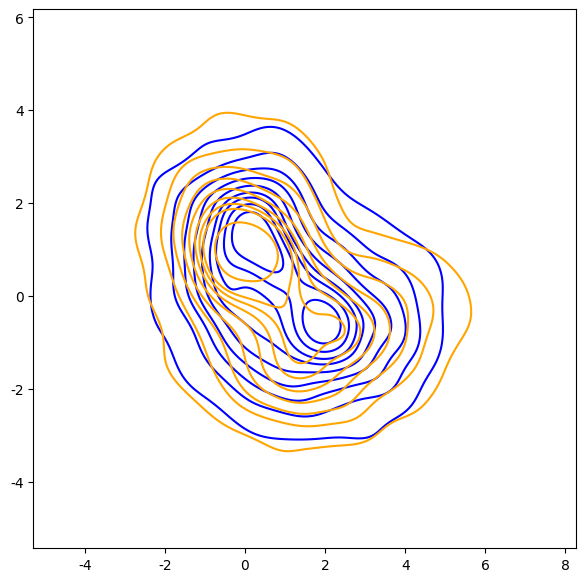

In [35]:
# @title Test the Learned Score by Reverse Diffusion
def reverse_diffusion_SDE_sampling(score_model_td, sampN=500, Lambda=5,
                                   nsteps=200, ndim=2, exact=False):
  """
  score_model_td: if `exact` is True, use a gmm of class GaussianMixture
                  if `exact` is False. use a torch neural network that takes vectorized x and t as input.
  """
  sigmaT2 = sigma_t_square(1, Lambda)
  xT = np.sqrt(sigmaT2) * np.random.randn(sampN, ndim)
  x_traj_rev = np.zeros((*xT.shape, nsteps, ))
  x_traj_rev[:, :, 0] = xT
  dt = 1 / nsteps
  for i in range(1, nsteps):
    t = 1 - i * dt
    tvec = torch.ones((sampN)) * t
    eps_z = np.random.randn(*xT.shape)
    if exact:
      gmm_t = diffuse_gmm(score_model_td, t, Lambda)
      score_xt = gmm_t.score(x_traj_rev[:, :, i-1])
    else:
      with torch.no_grad():
        score_xt = score_model_td(torch.tensor(x_traj_rev[:, :, i-1]).float(), tvec).numpy()
    x_traj_rev[:, :, i] = x_traj_rev[:, :, i-1] + eps_z * (Lambda ** t) * np.sqrt(dt) + score_xt * dt * Lambda**(2*t)
  return x_traj_rev


print("Sample with reverse SDE using the trained score model")
x_traj_rev_appr_denois = reverse_diffusion_SDE_sampling(score_model_td,
                                                        sampN=1000,
                                                        Lambda=25,
                                                        nsteps=200,
                                                        ndim=2)
print("Sample with reverse SDE using the exact score of Gaussian mixture")
x_traj_rev_exact = reverse_diffusion_SDE_sampling(gmm, sampN=1000,
                                                  Lambda=25,
                                                  nsteps=200,
                                                  ndim=2,
                                                  exact=True)
print("Sample from original Gaussian mixture")
X_samp, _, _ = gmm.sample(1000)

print("Compare the distributions")

fig, ax = plt.subplots(figsize=[7, 7])
handles = []
kdeplot(x_traj_rev_appr_denois[:, :, -1],
        label="Reverse diffusion (NN score learned DSM)", handles=handles, color="blue")
kdeplot(x_traj_rev_exact[:, :, -1],
        label="Reverse diffusion (Exact score)", handles=handles, color="orange")
kdeplot(X_samp, label="Samples from original GMM", handles=handles, color="red", hue="kind", fill=True,)
plt.axis("image")
plt.legend(handles=handles)
plt.show()

---
# Summary

Bravo, we have come a long way today! We learned about:

* The forward and reverse diffusion processes connect the data and noise distributions.
* Sampling involves transforming noise into data through the reverse diffusion process.
* Score function is the gradient to the data distribution, enabling the diffusion process's time reversal.
* By learning to denoise, we can learn the score function of data by a function approximator, e.g., neural network.

The math that empowers the diffusion models is the reversibility of this stochastic process. Here is the general result that, given a forward diffusion process,

\begin{equation}
d\mathbf{x} = \mathbf{f}(\mathbf{x}, t)dt + g(t)d \mathbf{w}
\end{equation}

There exists a reverse time stochastic process (reverse SDE)

\begin{equation}
d\mathbf{x} =  \bigg[\mathbf{f}(\mathbf{x}, t) - g^2(t) \nabla_\mathbf{x} \log p_t(\mathbf{x}) \bigg]dt + g(t) d \mathbf{w}.
\end{equation}

and a probability flow Ordinary Differential Equation (ODE)

\begin{equation}
d\mathbf{x} = \bigg[\mathbf{f}(\mathbf{x}, t) - \frac{1}{2}g^2(t) \nabla_\mathbf{x} \log p_t(\mathbf{x})\bigg] dt.
\end{equation}

such that solving the reverse SDE or the probability flow ODE amounts to the time reversal of the solution to the forward SDE.

By this math, simulating both the ODE and the SDE can sample from diffusion models.

**References**

* [Brian Anderson, (1986) Reverse-time diffusion equation models](https://www.sciencedirect.com/science/article/pii/0304414982900515)
* [Yang Song, et al. (2020) Score-Based Generative Modeling through Stochastic Differential Equations](https://arxiv.org/abs/2011.13456)

---
# Bonus: The Math behind Score Matching Objective

How to fit the score based on the samples, when we have no access to the exact scores?

This objective is called denoising score matching. Mathematically, it utilized this [equivalence relationship](https://animadversio.github.io/academic_notes/note-on-equiv-score-matching-objective) of the following objectives.

\begin{align}
J_{DSM}(\theta) &=\mathbb E_{\tilde x,x\sim p_t(\tilde x,x)} \|s_\theta(\tilde x)-\nabla_\tilde x\log p_t(\tilde x\mid x)\|^2\\
J_{ESM}(\theta) &=\mathbb E_{\tilde x\sim p_t(\tilde x)} \|s_\theta(\tilde x)-\nabla_\tilde x\log p_t(\tilde x)\|^2
\end{align}

In practise, it's to sample $x$ from data distribution, add noise with $\sigma$ and denoise it. Since we have at time $t$, $p_t(\tilde x\mid x)= \mathcal N(\tilde x;x,\sigma^2_t I)$, then $\tilde x=x+\sigma_t z,z\sim \mathcal N(0,I)$. Then

\begin{equation}
\nabla_\tilde x\log p_t(\tilde x|x)=-\frac{1}{\sigma_t^2}(x+\sigma_t z -x)=-\frac{1}{\sigma_t}z
\end{equation}

The objective simplifies into

\begin{equation}
\mathbb E_{x\sim p_0(x)}\mathbb E_{z\sim \mathcal N(0,I)} \|s_\theta(x+\sigma_t z)+\frac{1}{\sigma_t}z\|^2
\end{equation}

Finally, in the time dependent score model $s(x,t)$, to learn this for any time $t\in [\epsilon,1]$, we integrate over all $t$ with a certain weighting function $\gamma_t$ to emphasize certain part.

\begin{equation}
\int_\epsilon^1dt \gamma_t\mathbb E_{x\sim p_0(x)}\mathbb E_{z\sim \mathcal N(0,I)} \|s_\theta(x+\sigma_t z, t)+\frac{1}{\sigma_t}z\|^2
\end{equation}

(the $\epsilon$ is set to ensure numerical stability, as $t\to 0,\sigma_t\to 0$)
Now all the expectations could be easily evaluated by sampling.

A commonly used weighting is the following:

\begin{equation}
\int_\epsilon^1dt \mathbb E_{x\sim p_0(x)}\mathbb E_{z\sim \mathcal N(0,I)} \|\sigma_t s_\theta(x+\sigma_t z, t)+z\|^2
\end{equation}


<br>

**Reference**

* [Pascal Vincent (2011), A connection between score matching and denoising autoencoders](https://www.iro.umontreal.ca/~vincentp/Publications/smdae_techreport.pdf)


## Exercise - Comparing continuous SDE vs DDPM-style forward diffusion

In this exercise you will **compare the forward noising process** for:

1. A continuous-time **variance-exploding SDE** (VE SDE):
   - Forward SDE: d x(t) = g(t) d w(t)
   - Solution: x_t = x_0 + sigma(t) * eps, with eps ~ N(0, I)
   - We will use the "log-sigma" schedule:
     sigma(t) = sigma_min * (sigma_max / sigma_min)^t,  t in [0, 1].

2. A discrete **DDPM-style variance-preserving chain** (VP DDPM) with a *constant* beta:
   - One-step forward: x_{t+1} = sqrt(alpha) x_t + sqrt(1 - alpha) eps_t
     where alpha = 1 - beta.
   - Closed-form: x_t = sqrt(alpha^t) x_0 + sqrt(1 - alpha^t) eps.

Your goals:

1. Implement the two forward processes:
   - sde_forward(x0, t): given a batch x0 and a continuous time t in [0, 1].
   - ddpm_forward(x0, t, beta): given a batch x0 and an integer step t.

2. For a fixed mini-batch of images x0:
   - Visualize x_t at different noise levels for both processes.
   - Compare:
     - how quickly the images become noisy,
     - how the *effective* noise variance grows with t.

3. Plot sigma(t) for the SDE and sqrt(1 - alpha^t) for DDPM on the same figure
   (after mapping t to [0, 1] for DDPM) and comment on the differences.

Think about:

- In what sense can a discrete VP process approximate a continuous VE SDE?
- Why is it useful in practice to parameterize DDPM with these "alpha_t" and "alpha_bar_t"
  instead of directly choosing sigma(t)?


In [37]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import utils as vutils

# Use the same device convention as in the VAE notebook
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# ----- Continuous-time VE SDE forward process -----

def sigma_ve(t: torch.Tensor, sigma_min: float = 0.01, sigma_max: float = 50.0) -> torch.Tensor:
    """
    Log-sigma schedule for a variance-exploding (VE) SDE:

        sigma(t) = sigma_min * (sigma_max / sigma_min)**t,   t in [0, 1]

    Args:
        t: tensor in [0, 1], any shape (broadcasting-friendly).
    Returns:
        sigma(t) with the same shape as t.
    """
    t = t.to(dtype=torch.float32)
    c = sigma_max / sigma_min
    return sigma_min * (c ** t)


def sde_forward(x0: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    """
    Forward diffusion for VE SDE:

        x_t = x_0 + sigma(t) * eps,   eps ~ N(0, I).

    Args:
        x0: clean batch, shape [B, C, H, W]
        t: times in [0, 1], shape [B] or [B, 1]

    Returns:
        x_t: noised batch, same shape as x0.
    """
    B = x0.size(0)

    # Ensure t has shape [B, 1, 1, 1] so it broadcasts over [C, H, W]
    if t.dim() == 1:
        t = t.view(B, 1, 1, 1)
    elif t.dim() == 2:
        t = t.view(B, 1, 1, 1)
    else:
        t = t.view(B, 1, 1, 1)

    sigma_t = sigma_ve(t)  # [B, 1, 1, 1], broadcasts over channels and spatial dims

    eps = torch.randn_like(x0)
    x_t = x0 + sigma_t * eps
    return x_t


# ----- Discrete DDPM-style VP forward process with constant beta -----

def ddpm_alpha_bar(t: torch.Tensor, beta: float) -> torch.Tensor:
    """
    For constant beta, the DDPM variance-preserving chain satisfies:

        alpha = 1 - beta
        alpha_bar_t = alpha^t

    Args:
        t: integer time steps (tensor)
        beta: scalar in (0, 1)

    Returns:
        alpha_bar_t with the same shape as t.
    """
    alpha = 1.0 - beta
    t = t.to(dtype=torch.float32)
    return alpha ** t


def ddpm_forward(x0: torch.Tensor, t: torch.Tensor, beta: float = 0.02) -> torch.Tensor:
    """
    Forward diffusion for a DDPM-style variance-preserving (VP) process
    with constant beta:

        x_t = sqrt(alpha_bar_t) * x_0 + sqrt(1 - alpha_bar_t) * eps
        eps ~ N(0, I)

    Args:
        x0: clean batch, shape [B, C, H, W]
        t: integer steps, shape [B] or [B, 1] with values in {0, 1, ..., T}
        beta: constant noise rate

    Returns:
        x_t: noised batch, same shape as x0.
    """
    B = x0.size(0)

    # Flatten t to [B] for computing alpha_bar_t
    if t.dim() == 1:
        t_flat = t
    elif t.dim() == 2:
        t_flat = t.squeeze(-1)
    else:
        t_flat = t.view(-1)

    alpha_bar_flat = ddpm_alpha_bar(t_flat, beta=beta)  # [B]
    alpha_bar = alpha_bar_flat.view(B, 1, 1, 1)         # [B, 1, 1, 1] for broadcasting

    eps = torch.randn_like(x0)

    c1 = torch.sqrt(alpha_bar)
    c2 = torch.sqrt(1.0 - alpha_bar)
    x_t = c1 * x0 + c2 * eps
    return x_t


# ----- Helper for visualization on a minibatch -----

@torch.no_grad()
def compare_forward_noising(
    data_loader,
    num_images: int = 8,
    t_sde: float = 0.5,
    t_ddpm: int = 500,
    beta_ddpm: float = 0.02,
):
    """
    Compare VE SDE vs DDPM VP noising at "similar" times.

    - Takes one minibatch x0 from data_loader.
    - Applies sde_forward at time t_sde in [0, 1].
    - Applies ddpm_forward at discrete step t_ddpm (0 <= t_ddpm <= T).
    - Plots three rows:
        row 1: original images
        row 2: VE SDE noised images
        row 3: DDPM noised images
    """
    x0, _ = next(iter(data_loader))
    x0 = x0.to(device)[:num_images]

    # Time tensors for each image
    t_sde_tensor = torch.full((num_images,), t_sde, device=device)
    t_ddpm_tensor = torch.full((num_images,), float(t_ddpm), device=device)

    x_sde = sde_forward(x0, t_sde_tensor)
    x_ddpm = ddpm_forward(x0, t_ddpm_tensor, beta=beta_ddpm)

    # Stack originals and noised versions
    originals = x0.cpu()
    sde_cpu = x_sde.cpu()
    ddpm_cpu = x_ddpm.cpu()

    all_imgs = torch.cat([originals, sde_cpu, ddpm_cpu], dim=0)

    grid = vutils.make_grid(all_imgs, nrow=num_images, padding=2)
    npimg = grid.numpy()

    plt.figure(figsize=(1.5 * num_images, 4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation="nearest")
    plt.axis("off")
    plt.title(
        f"Top: original  -  middle: VE SDE t={t_sde}  -  bottom: DDPM t={t_ddpm}, beta={beta_ddpm}"
    )
    plt.show()


# OPTIONAL: compare the scalar noise levels

def plot_noise_levels(
    num_steps: int = 1000,
    beta: float = 0.02,
    sigma_min: float = 0.01,
    sigma_max: float = 50.0,
):
    """
    Plot:
      - sigma(t) for VE SDE with t in [0, 1],
      - sqrt(1 - alpha_bar_t) for DDPM VP with t = 0,...,num_steps.

    This shows how the two forward processes increase their noise level.
    """
    # Continuous times for SDE
    t_cont = torch.linspace(0.0, 1.0, steps=num_steps)
    sigma_t = sigma_ve(t_cont, sigma_min=sigma_min, sigma_max=sigma_max)

    # Discrete steps for DDPM
    t_disc = torch.arange(num_steps + 1)
    alpha_bar = ddpm_alpha_bar(t_disc, beta=beta)
    std_ddpm = torch.sqrt(1.0 - alpha_bar)

    # Normalize DDPM time to [0, 1] for comparison
    t_disc_norm = t_disc.float() / num_steps

    plt.figure(figsize=(5, 4))
    plt.plot(t_cont.numpy(), sigma_t.numpy(), label="VE SDE sigma(t)")
    plt.plot(t_disc_norm.numpy(), std_ddpm.numpy(), label=r"DDPM sqrt(1 - alpha_bar_t)")
    plt.xlabel("time (normalized)")
    plt.ylabel("effective noise scale")
    plt.title("Noise growth: VE SDE vs DDPM VP (constant beta)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


### Questions

1. Visually, for the same "effective" noise level, do the VE SDE and DDPM VP
   noising processes produce similar looking corrupted images?
2. Look at the noise-scale curves:
   - How smooth is sigma(t) for the SDE?
   - How does the DDPM curve behave as a function of discrete steps?
3. How could you choose a beta schedule in DDPM so that
   sqrt(1 - alpha_bar_t) approximates a given sigma(t) from a continuous SDE?


In [39]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Simple demo dataset and loader just for the forward-diffusion comparison
transform = transforms.ToTensor()

demo_dataset = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform,
)

demo_loader = DataLoader(
    demo_dataset,
    batch_size=64,
    shuffle=True,
)

print("Demo loader ready. Number of samples:", len(demo_dataset))


100%|██████████| 9.91M/9.91M [00:04<00:00, 2.16MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 169kB/s]
100%|██████████| 1.65M/1.65M [00:02<00:00, 754kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 549kB/s]

Demo loader ready. Number of samples: 60000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.0690885..3.5441122].


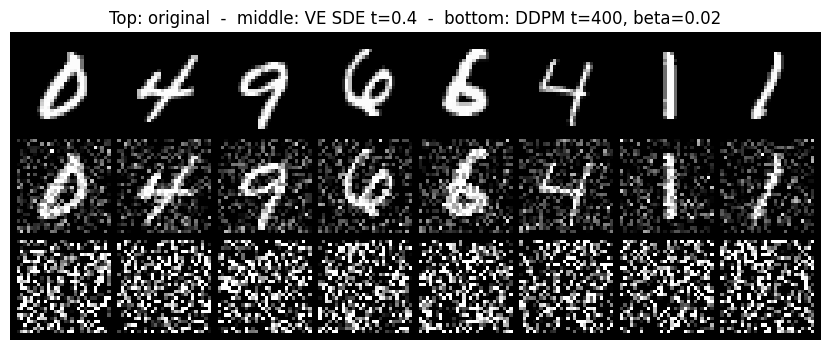

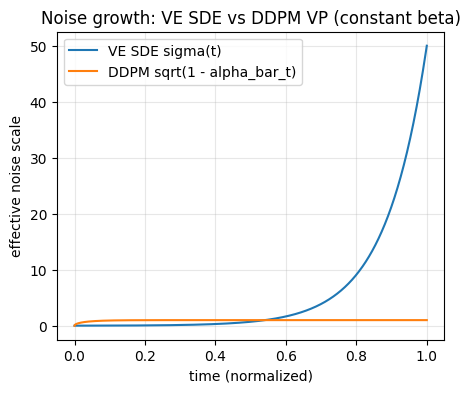

In [41]:
# 1) Visual comparison on a single minibatch
compare_forward_noising(
    data_loader=demo_loader,
    num_images=8,
    t_sde=0.4,      # continuous time in [0, 1]
    t_ddpm=400,     # discrete step index (0..T)
    beta_ddpm=0.02,
)

# 2) Compare noise level schedules
plot_noise_levels(
    num_steps=1000,
    beta=0.02,
    sigma_min=0.01,
    sigma_max=50.0,
)
